Import the necessary libraries

In [1]:
import math
from math import sin, cos, tan, sqrt, radians, exp
import matplotlib.pyplot as plt

The function below is for the acceleration. It takes and input of the velocities in Cartesian dimensions as well as a list of properties and outputs the respective accelerations. It utilizes a get_B_value function to get drag force information using either a well fitting function or more specific ones if accounting for the roughness of the ball.

In [2]:
def accel(vx, vy, vz, props):
    """
    Input velocity components, list of properties and updates of the ball

    Output acceleration
    """
    g = 9.8
    v = sqrt((vx**2)+(vy**2))
    m = props[0]    
    B = get_B_value(props, m, v)
    
   

    if props[5] == 0:
        v_wind = props[3]
        v_minus_vwind = sqrt(((vx-v_wind)**2)+(vy**2))
        ax = -(B)*(v_minus_vwind)*(vx-v_wind)/m
        ay = -g-(B)*(v_minus_vwind)*(vy)/m
        az = 0

    else:
        v_wind = props[5]
        v_minus_vwind = sqrt(((vz-v_wind)**2)+(vy**2)+(vx**2))
        ax = -(B)*(v_minus_vwind)*(vx)/m
        ay = -g-(B)*(v_minus_vwind)*(vy)/m
        az = -(B)*(v_minus_vwind)*(vz-v_wind)/m


    return (ax, ay, az)

def get_B_value(props, m, v):
    roughness = props[4]
    air_density = 1.225
    xsection_area_baseball = 0.0042

    if roughness == 'Normal':
        B = (0.0039 + 0.0058/(1+exp((v - 35)/5))) * m
        # print(B)
    elif roughness == 'Rough':
        point1v = 50/2.237
        point2v = 75/2.237
        point3v = 150/2.237
        point4v = 200/2.237

        if v < point1v:
            C = 0.5
        elif v < point2v:
            C = (-0.4/(point2v-point1v))*(v-point1v)+0.5
        else:
            C = (0.2/(point3v-point2v))*(v-point2v)+0.1

        B = 0.5*(C)*(air_density)*(xsection_area_baseball)

    elif roughness == 'Smooth':
        point1v = 50/2.237
        point2v = 75/2.237
        point3v = 150/2.237
        point4v = 200/2.237

        if v < point3v:
            C = 0.5
        else:
            C = (-0.4/(point4v-point3v))*(v-point4v)+0.1

        B = 0.5*(C)*(air_density)*(xsection_area_baseball)

    return B

Utilize a 4th order Runge-Kutta numerical integrator to evolve the second order differential equation forward in time. 

In [3]:
def my_rk(t, props, deltat):
    """
    Input time, list of properties and updates of the ball, and a time-step size

    Output velocity components and time
    """
    # Take some time and return vx vy at that time, using 4th order Runge Kutta method

    # x-velocity
    # Get velocity steps
    x1, y1, z1, v1x, v1y, v1z, time = props[-1][-1]
    rk1 = (v1x, v1y, v1z)


    v2x, v2y, v2z = (v1x + accel(v1x, v1y, v1z, props)[0]*(deltat/2), v1y + accel(v1x, v1y, v1z, props)[1]*(deltat/2), v1z + accel(v1x, v1y, v1z, props)[2]*(deltat/2))
    rk2 = (v2x, v2y, v2z)

    v3x, v3y, v3z = (v1x + accel(v2x, v2y, v2z, props)[0]*(deltat/2), v1y + accel(v2x, v2y, v2z, props)[1]*(deltat/2), v1z + accel(v2x, v2y, v2z, props)[2]*(deltat/2))
    rk3 = (v3x, v3y, v3z)

    v4x, v4y, v4z = (v1x + accel(v3x, v3y, v3z, props)[0]*(deltat), v1y + accel(v3x, v3y, v3z, props)[1]*(deltat), v1z + accel(v3x, v3y, v3z, props)[2]*(deltat))
    rk4 = (v4x, v4y, v4z)


    x = x1 + (deltat/6)*(rk1[0] + 2*rk2[0] + 2*rk2[0] + rk4[0])
    y = y1 + (deltat/6)*(rk1[1] + 2*rk2[1] + 2*rk3[1] + rk4[1])
    z = z1 + (deltat/6)*(rk1[2] + 2*rk2[2] + 2*rk3[2] + rk4[2])

    # Get runge kutta steps velocity
    rk1 = accel(v1x, v1y, v1z, props)
    rk2 = accel(v2x, v2y, v2z, props)
    rk3 = accel(v3x, v3y, v3z, props)
    rk4 = accel(v4x, v4y, v4z, props)

    vx = v1x + (deltat/6)*(rk1[0] + 2*rk2[0] + 2*rk2[0] + rk4[0])
    vy = v1y + (deltat/6)*(rk1[1] + 2*rk2[1] + 2*rk3[1] + rk4[1])
    vz = v1z + (deltat/6)*(rk1[2] + 2*rk2[2] + 2*rk3[2] + rk4[2])


    return (x, y, z, vx, vy, vz, t)

Create a function, 'system', to initialize the motion of the ball and fun the functions above.

In [4]:
def system(props):
    """
    Input list of properties of the ball and the system

    Output updated list with positions and velocities with respect to time
    """

    # Unit conversions (mph to m/s, degrees to radians)
    props[1] /= 2.237
    props[3] /= 2.237
    props[2] = radians(props[2])

    # Initialize deltat (had floating point issues)
    deltat = props[-2]
 
    # Initialize list of velocities
    vx = (props[1])*(cos(props[2]))
    vy = (props[1])*(sin(props[2]))
    vz = 0
    props[-1].append((0, 1, 0, vx, vy, vz, 0))

    starting_vy = vy
    t = deltat

    if props[2] > 0.087:
        while props[-1][-1][1] >= -(starting_vy):
            props[-1].append(my_rk(t, props, deltat))
            t += deltat
    else:
        num_steps = sqrt(4/9.8)/deltat
        for i in range(int(num_steps) + 1):
            props[-1].append(my_rk(t, props, deltat))
            t += deltat


    for i in range(len(props[-1])):
        if props[-1][i][1] < 0:
            props[-1] = props[-1][:i]
            break

    return props

Plotting function for data visualization (utilized in the main())

In [5]:
def plot_data(information, input, title):
    """
    Input list of properties and updates of the ball, and a command

    Produces Plots

    Returns None
    """
    if title == 'Varying Initial Speed':
        data1, data2, data3 = tuple(information)
        # Unpack the tuples into separate lists for x and y
        x_values1, y_values1, z_values1, vx, vy, vz, t = zip(*data1[-1])
        x_values2, y_values2, z_values2, vx, vy, vz, t = zip(*data2[-1])
        x_values3, y_values3, z_values3, vx, vy, vz, t = zip(*data3[-1])

       
        # Plot the data
        plt.plot(x_values1, y_values1, label='100 mph')
        plt.plot(x_values2, y_values2, label='110 mph')
        plt.plot(x_values3, y_values3, label='120 mph')


        # Add labels and title
        plt.xlabel('x-pos')
        plt.ylabel('y-pos')
        plt.title(title)


        # Show the plot
        plt.show()
    elif input == 'kinetic':
        data1, data2 = information
      

        plt.plot(data1, data2, label='')

        # Add labels and title
        plt.xlabel('Initial Kinetic Energy')
        plt.ylabel('Range')
        plt.title(title)


        # Show the plot
        plt.show()
        
    elif input == 'p':
        data1, data2, data3 = tuple(information)
        # Unpack the tuples into separate lists for x and y
        x_values1, y_values1, z_values1, vx, vy, vz, t = zip(*data1[-1])
        x_values2, y_values2, z_values2, vx, vy, vz, t = zip(*data2[-1])
        x_values3, y_values3, z_values3, vx, vy, vz, t = zip(*data3[-1])

       
        # Plot the data
        plt.plot(x_values1, y_values1, label='0 mph')
        plt.plot(x_values2, y_values2, label='- 25 mph')
        plt.plot(x_values3, y_values3, label='25 mph')


        # Add labels and title
        plt.xlabel('x-pos')
        plt.ylabel('y-pos')
        plt.title(f"Positions in -25, 0, 25 mph wind")


        # Show the plot
        plt.show()
    elif input == 'crosswind':
        data = information[-1]
        # Unpack the tuples into separate lists for x and y
        x_values, y_values, z_values, vx, vy, vz, t = zip(*data)

        # Create a figure and a 3D axis
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot data
        ax.plot(x_values, z_values, y_values)

        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_zlabel('Y')
        ax.set_title(title)

        # Show plot
        plt.show()
    elif input == 'a_r':
        angles1, ranges1 = zip(*information[0])
        angles2, ranges2 = zip(*information[1])
        angles3, ranges3 = zip(*information[2])

        plt.plot(angles1, ranges1, label='0 mph wind')
        plt.plot(angles2, ranges2, label='- 25 mph wind')
        plt.plot(angles3, ranges3, label='25 mph wind')

        
        # Add labels and title
        plt.xlabel('Angle')
        plt.ylabel('Range')
        plt.title(title)

        # Show the plot
        plt.show()
    elif input == 'fastball':
        data1, data2 = tuple(information)
        x_values1, y_values1, z_values1, vx, vy, vz, t = zip(*data1)

        # Plot the data
        plt.plot(x_values1, data2, label='')


        # Add labels and title
        plt.xlabel('Time')
        plt.ylabel('X-pos')
        plt.title(title)


        # Show the plot
        plt.show()


    elif input == 'r':
        data1, data2 = tuple(information)
        # Unpack the tuples into separate lists for x and y
        x_values1, y_values1, z_values1, vx, vy, vz, t = zip(*data1[-1])
        x_values2, y_values2, z_values2, vx, vy, vz, t = zip(*data2[-1])

       
        # Plot the data
        plt.plot(x_values1, y_values1, label='Rough Ball')
        plt.plot(x_values2, y_values2, label='Smooth Ball')


        # Add labels and title
        plt.xlabel('x-pos')
        plt.ylabel('y-pos')
        plt.title(title)


        # Show the plot
        plt.show()
    return

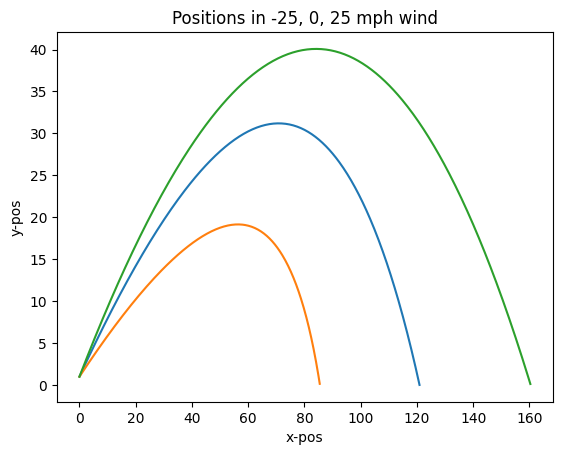


PART B

No wind:
 	 max range = 120.92170343535417 m 
 	 max range angle = 36.0 degrees
10 mph head wind:
 	 max range = 85.44481719765267 m 
 	 max range angle = 27.0 degrees
10 mph tail wind:
 	 max range = 160.33356168706598 m 
 	 max range angle = 41.0 degrees 




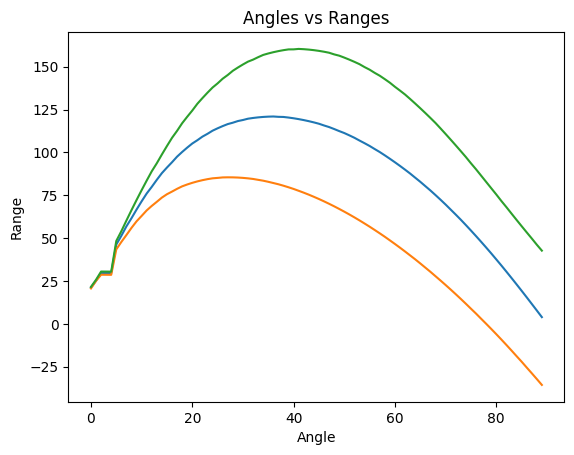


PART C

100 mph initial velocity range: 104.3315065385283 m
110 mph initial velocity range: 120.83616925041625 m
120 mph initial velocity range: 137.5370301242816 m


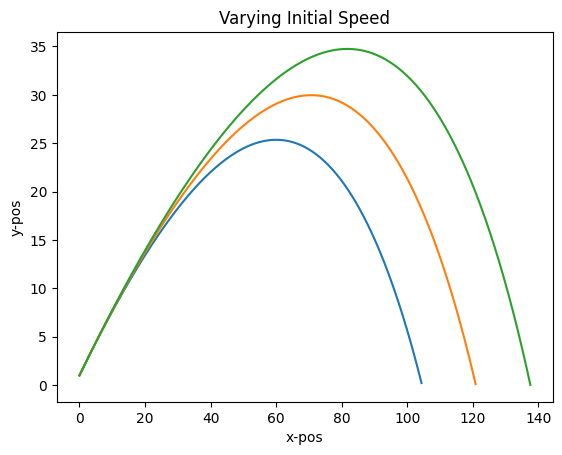

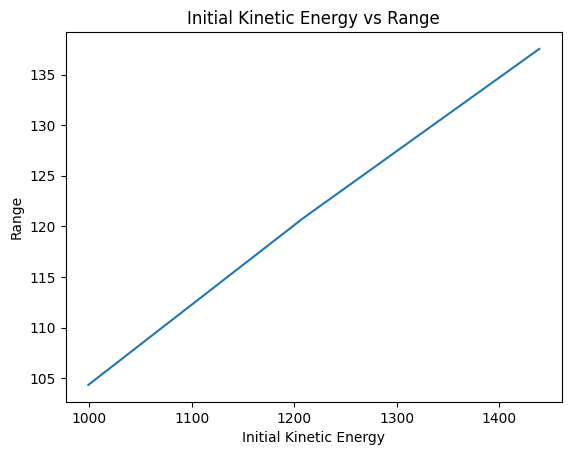


PART D


total time of fastball to homebase = 0.4350000000000003 seconds


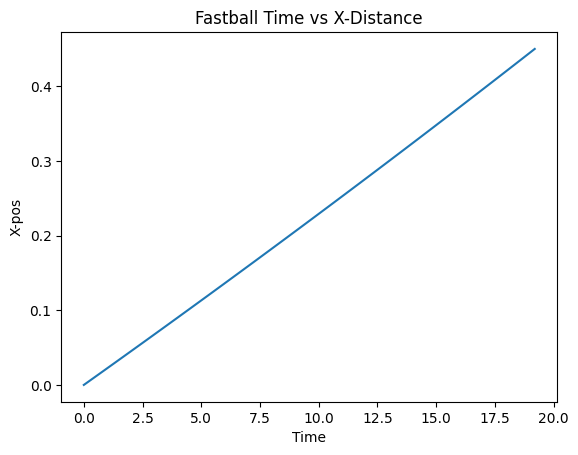

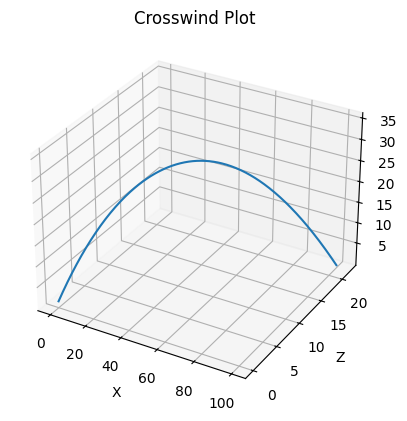

Rough ball range: 193.03610374171745
Smooth ball range: 171.05943282608217


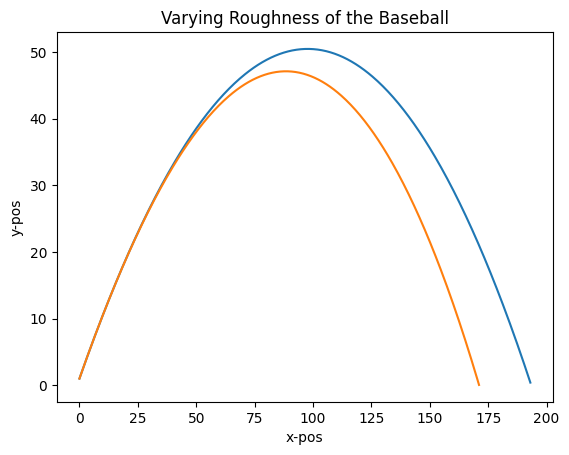

In [6]:
def main():
    # Properties of the system [mass, initial speed, intitial angle, wind (+ = tailwind), B (for roughness), crosswind, deltat, positions, velocities, time]
    
    # PART A and B
    deltat = 0.015
    m = 1

    three_wind_results = []
    angles_ranges = []
    for wind in (0, -25, 25):
            angles_ranges.append([])
            previous = 0
            for angle in range(0, 90):
                props_initial = [m, 110, angle, wind, 'Normal', 0, deltat, []] 
                result = system(props_initial)
                baseball_range = result[-1][-1][0]
                angles_ranges[-1].append((angle, baseball_range))
                if baseball_range > previous:
                    biggest_result = result
                    previous = baseball_range
            three_wind_results.append(biggest_result)


    # Plot the data
    plot_data(three_wind_results, 'p', None)


    ranges = []
    angles = []
    for result in three_wind_results:
        ranges.append(result[-1][-1][0])
        angles.append(result[2]*180/(math.pi))
    print("\nPART B\n")
    print(f"No wind:\n \t max range = {ranges[0]} m \n \t max range angle = {angles[0]} degrees")
    print(f"10 mph head wind:\n \t max range = {ranges[1]} m \n \t max range angle = {angles[1]} degrees")
    print(f"10 mph tail wind:\n \t max range = {ranges[2]} m \n \t max range angle = {angles[2]} degrees \n\n")
        

    
  
    plot_data(angles_ranges, 'a_r', 'Angles vs Ranges')


    # PART C
    print("\nPART C\n")
    results_C = []
    kinetic_list = []
    ranges_C = []
    for speed in (100, 110, 120):
            kinetic_list.append(0.5*m*((speed/2.237)**2))

            props_initial = [m, speed, 35, 0, 'Normal', 0, deltat, []] 
            result = system(props_initial)
            results_C.append(result)
            baseball_range = result[-1][-1][0]
            ranges_C.append(baseball_range)

            print(f"{speed} mph initial velocity range: {baseball_range} m")

    plot_data(results_C, 'p', 'Varying Initial Speed')
    plot_data((kinetic_list, ranges_C), 'kinetic', 'Initial Kinetic Energy vs Range')




    # PART D
    print("\nPART D\n")
    properties = [1, 100, 0, 0, 'Normal', 0, deltat, []]
    positions = system(properties)[-1]
    time_list = []
    previous = 10
    for position in positions:
        differential = (position[0] - 60.5/3.281)
        time_list.append(position[-1])
        if abs(differential) < abs(previous):
            homebase_t = position[-1]
            previous = differential
    
    try:
        print(f"\ntotal time of fastball to homebase = {homebase_t} seconds")
    except UnboundLocalError:
        print("\nCalculation Error: DECREASE DELTAT")


    
    plot_data((positions, time_list), 'fastball', 'Fastball Time vs X-Distance')

   



    crosswind = 10

    props_214 = [1, 100, 45, 0, 'Normal', crosswind, deltat, []] 

    results_214 = system(props_214)

    plot_data(results_214, 'crosswind', 'Crosswind Plot')


    
    # ---------------> rough, normal, smooth
    textures_list = ('Rough', 'Smooth')
    roughness_ranges = []
    for roughness in textures_list:
        props_215 = [1, 100, 45, 0, roughness, 0, deltat, []] 
        props_updated = system(props_215)
        range_215 = props_updated[-1][-1][0]
        print(f"{roughness} ball range: {range_215}")
        roughness_ranges.append(props_updated)
    
    plot_data(roughness_ranges, 'r', 'Varying Roughness of the Baseball')

    
main()

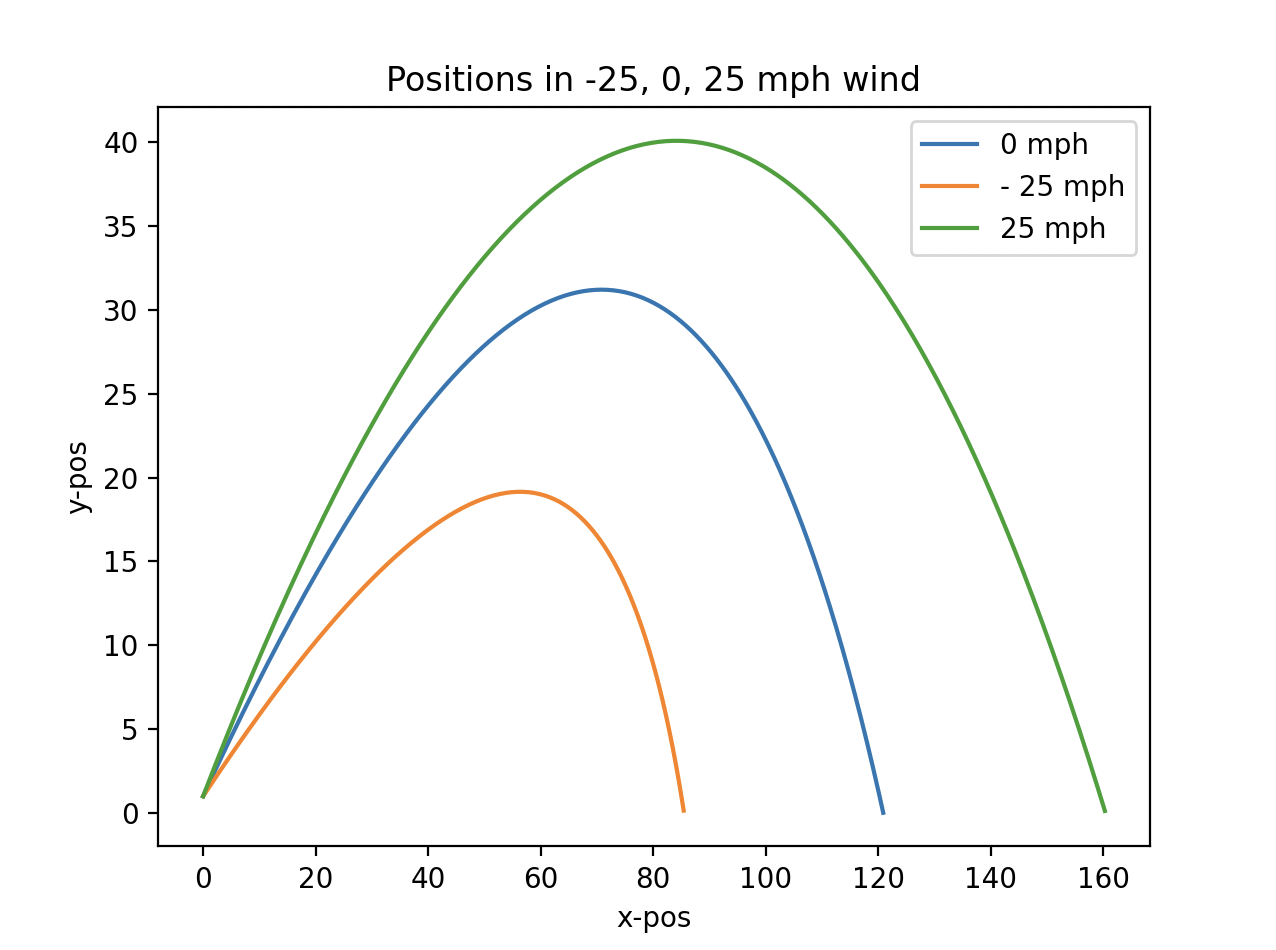

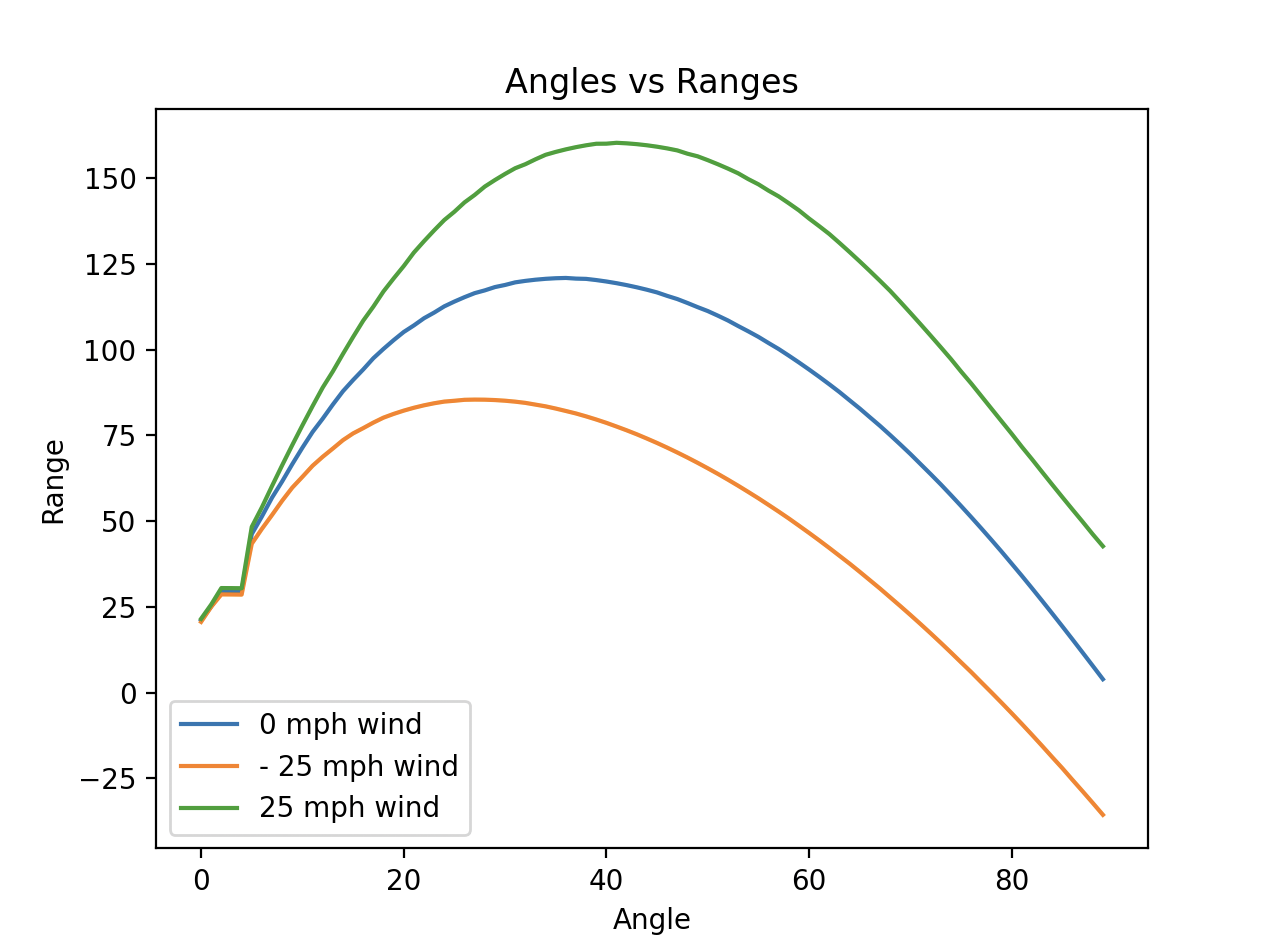

The plots above are of a baseball weighing 1kg, hit at an initial speed of 110 mph, evaluated over a timestep of 0.015 seconds. Every angle from 0-90 degrees is evaluated and graphed against the range produced to determine which angle had the largest range for each wind situation. As seen from the standard output above, the max-range angle for no wind was 36 degrees, for 10 mph head wind was 27 degrees, and for 10 mph tail wind was 41 degrees.

QUESTION 2.13 (C)

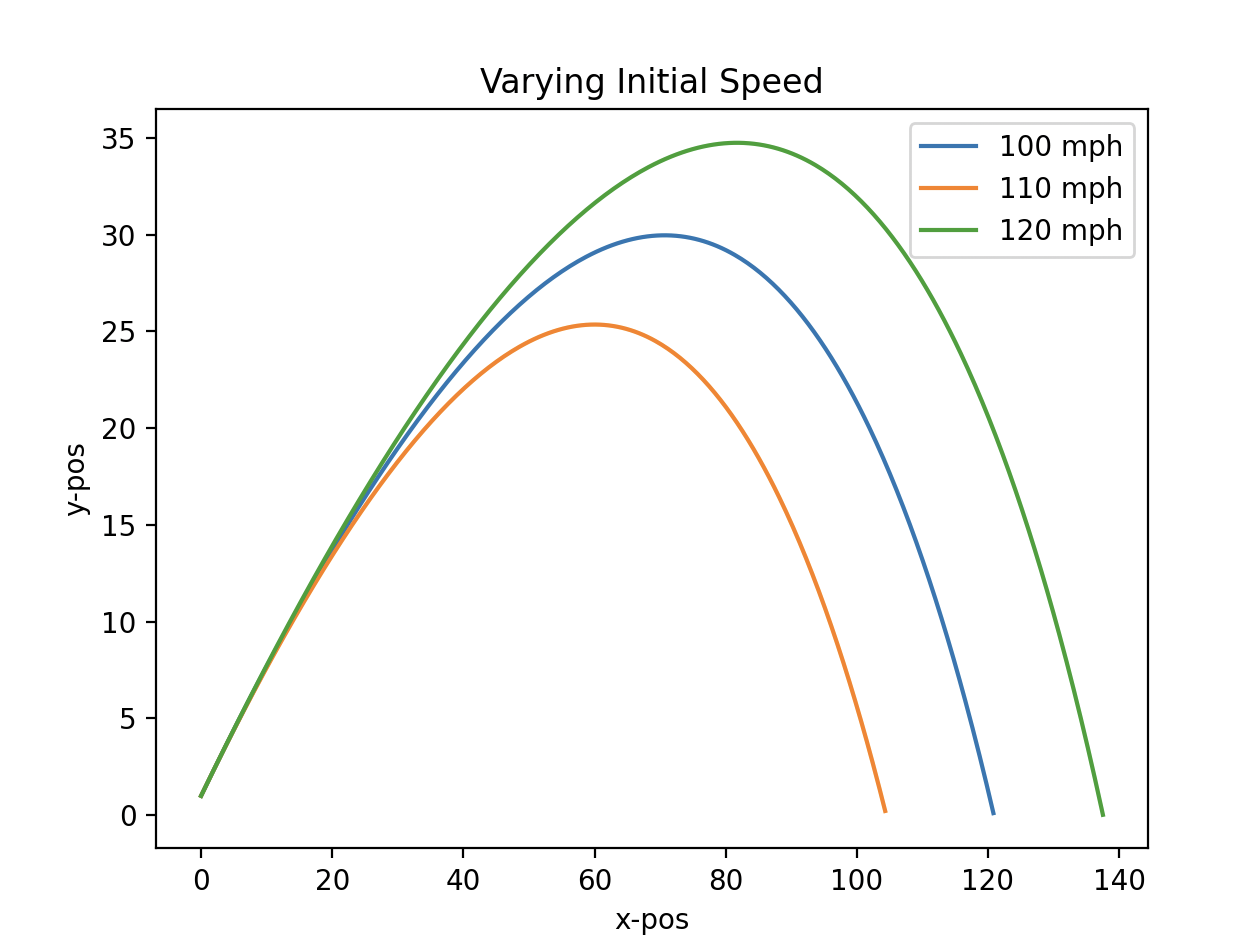

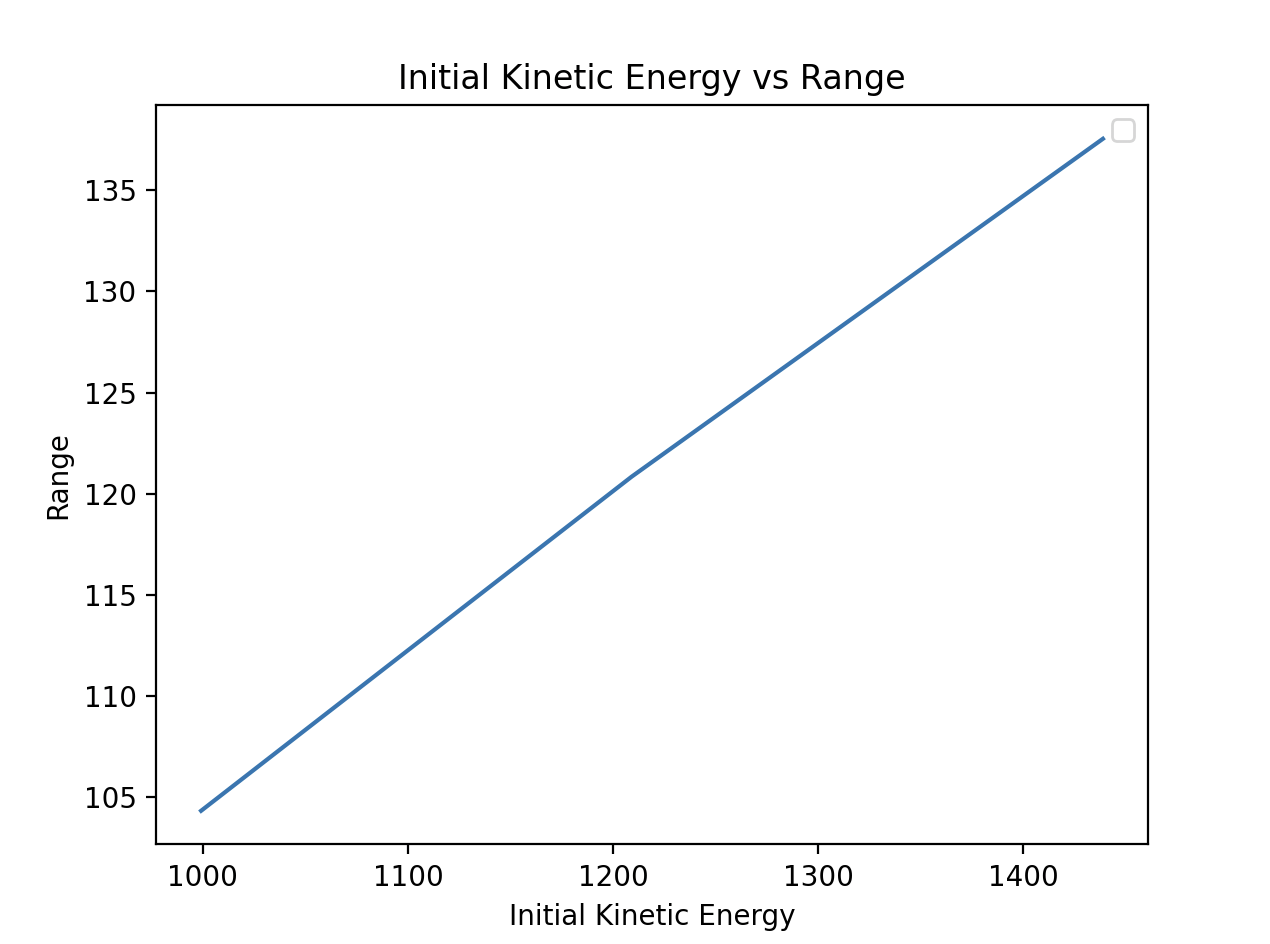

For part C, the range of the baseball is calculated and ploted above. As expected, a higher initial velocity indicates a larger range of the baseball. Furthermore, this indicates that higher initial kinetic energy results in higher range, and from the three data points, the relationship seems to be linear, as shown in the plot above.

QUESTION 2.13 (D)

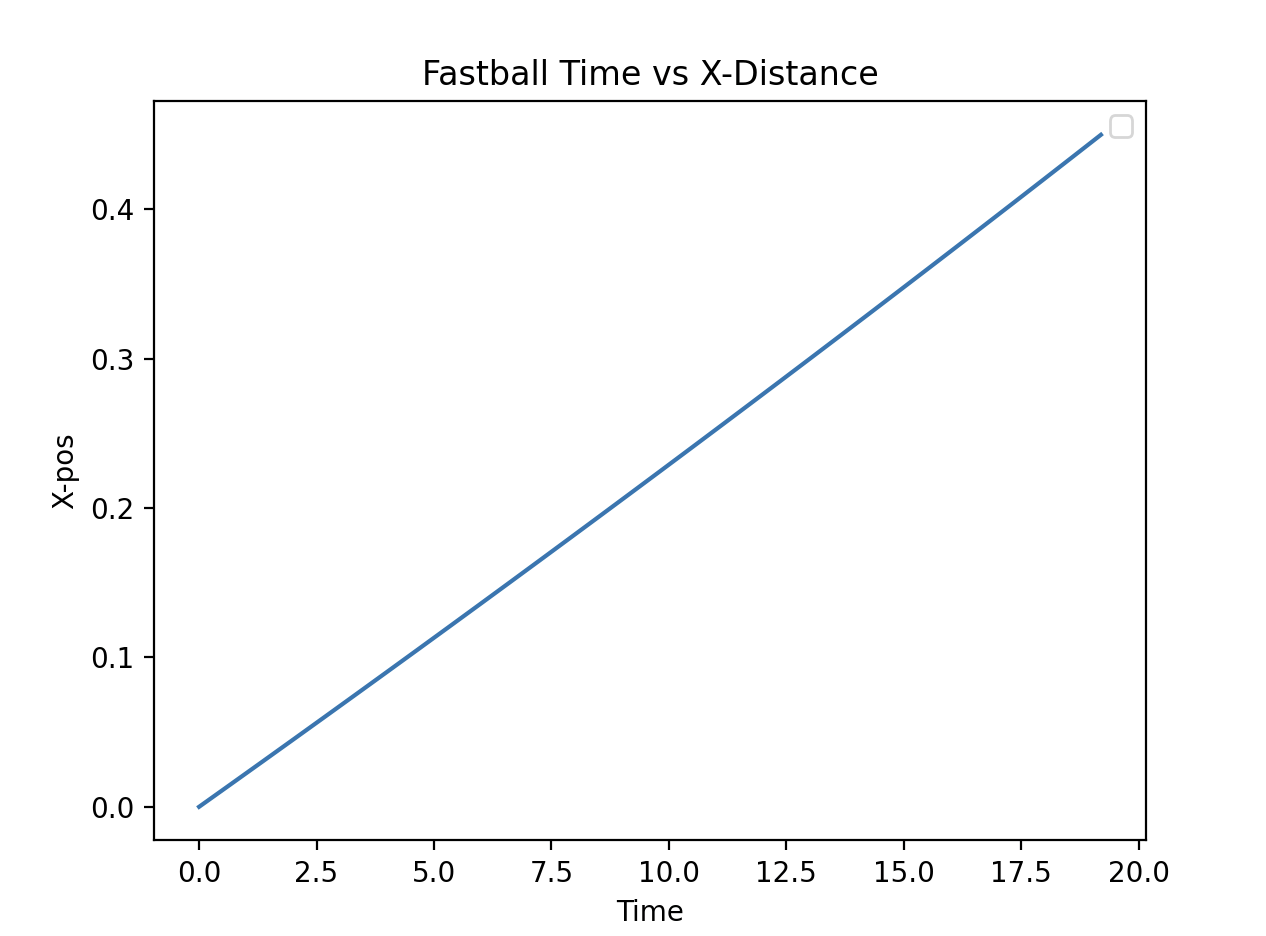

By setting the initial angle with the horizontal as zero, we can simulate a fastball from the pitcher, and can get to within deltat of the actual time from the pitcher to homebase using this program.

QUESTION 2.14

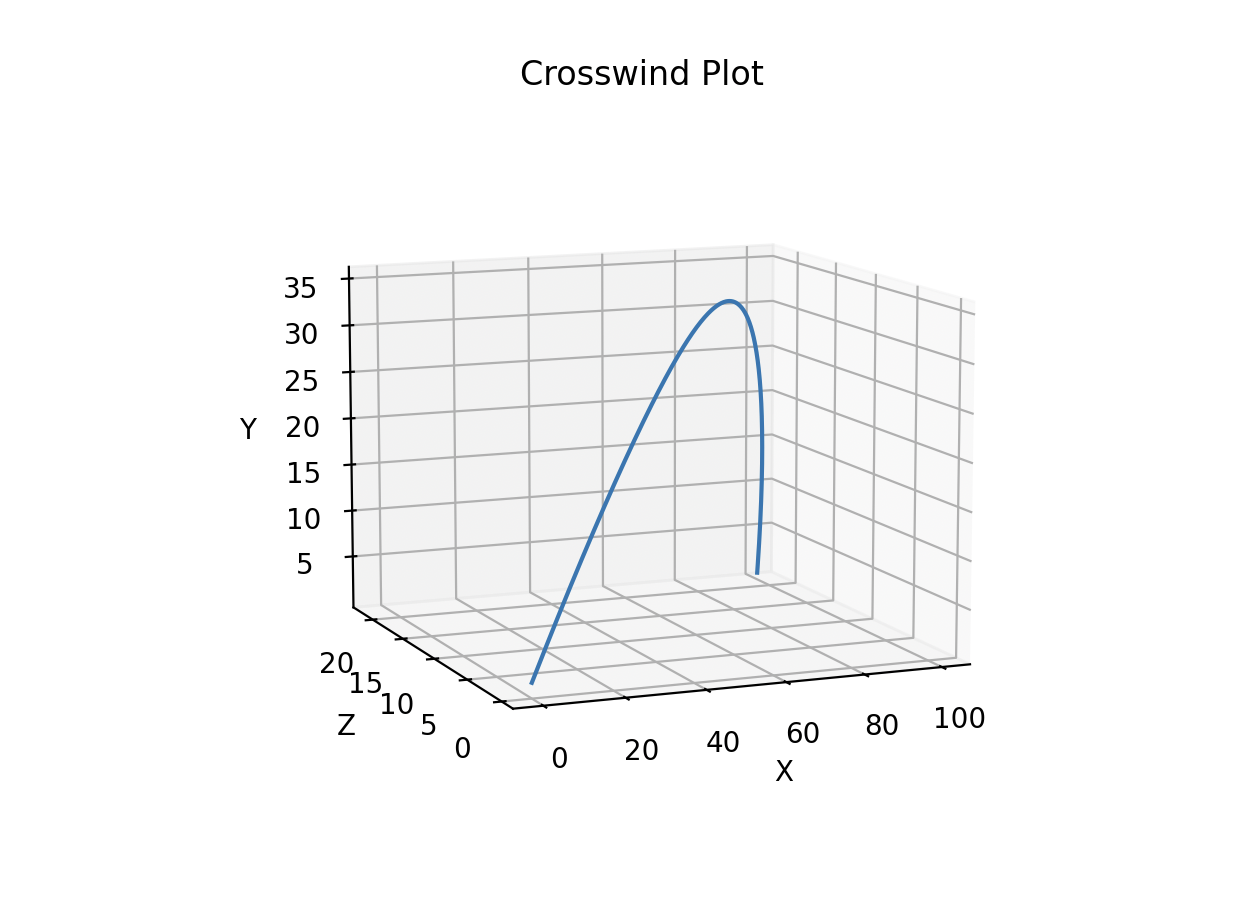

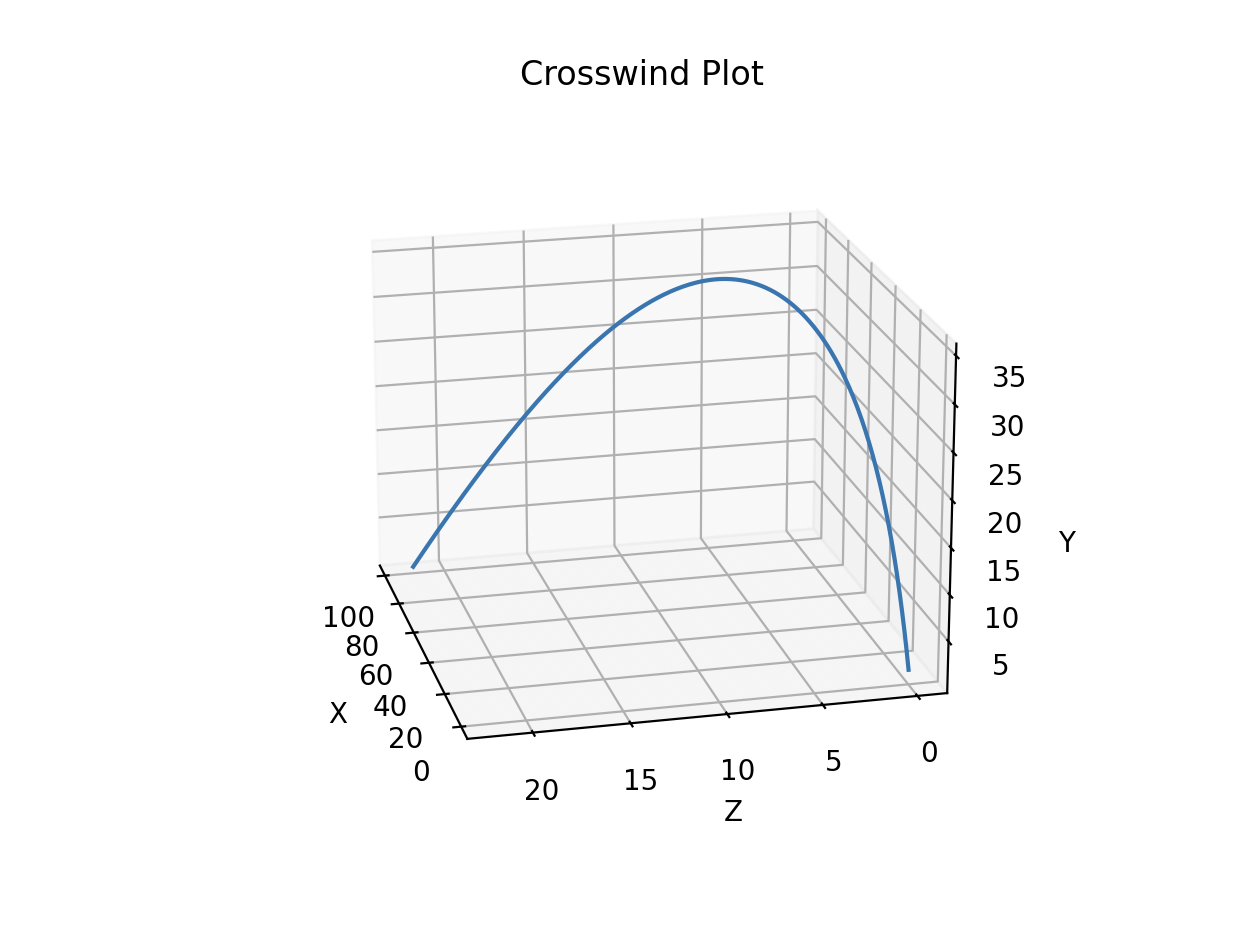

The plot above is of the baseball trajectory while incorporating 10 mph of crosswind in the +z direction, and thus introducing a third dimension.

QUESTION 2.15

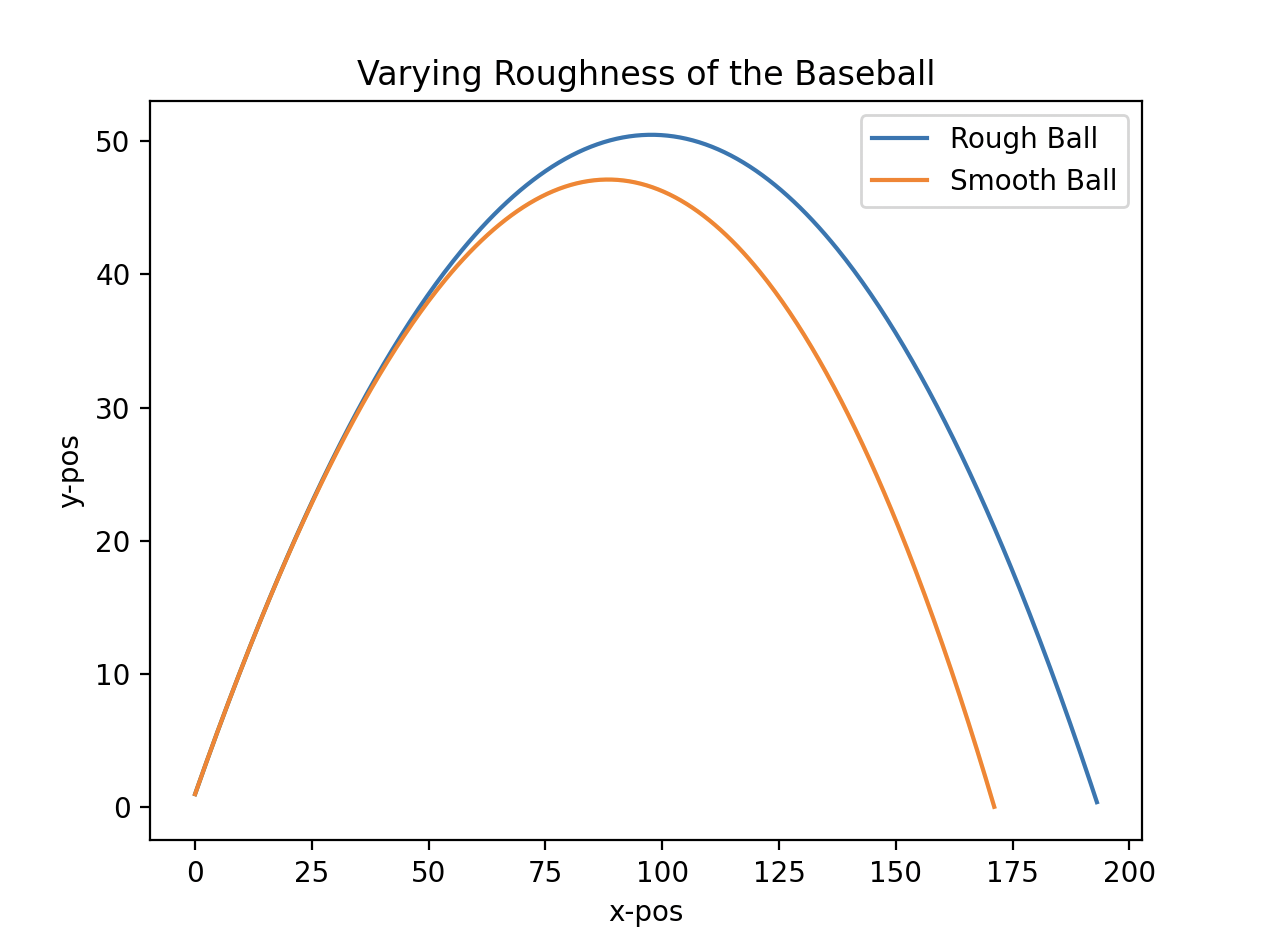

Using an abbreviated (non exact) model for the coefficient of drag based on the graph in the textbook, the program simulates the trajectory of two balls with different textures. As seen above, the smooth ball had less range than the rough one, which aligns with the theory.